# TreePPL in Jupyter: Writing and Running Programs

In [1]:
import treeppl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import clear_output

sns.set_theme()

## Introduction

Let’s load the TreePPL extension for Jupyter, which provides an easy-to-use interface for working with TreePPL directly within Jupyter notebooks:

In [2]:
%load_ext treeppl.ipython

<IPython.core.display.Javascript object>

Once the extension is loaded, users can use the `%%treeppl` cell magic to write and compile a TreePPL program. Executing the cell creates a `treeppl.Model` object, which allows interaction with the compiled program directly in Python. This object is stored in a Python variable specified as an argument to the `%%treeppl` magic (i.e., immediately following `%%treeppl` on the first line). Optionally, the variable name can be followed by parameters and values. Most of these are passed to the TreePPL compiler, except for the `samples` parameter, which specifies the number of samples to draw when the program is executed. Examples are provided below.

The extension also supports basic syntax highlighting for TreePPL programs.

For example, the following cell demonstrates a simple TreePPL program for simulating the flip of a fair coin:

In [3]:
%%treeppl flip samples=10

model function flip() => Bool {
  assume p ~ Bernoulli(0.7);
  return p;
}

In this example, a `treeppl.Model` instance is created, and the program is compiled. The variable name `flip` (specified after `%%treeppl`) provides an interface for interacting with the model. The argument `samples=10` specifies the number of samples to generate when the program is executed.

To run the TreePPL program, simply call the variable as a function (e.g., `flip()`). This executes the program and returns a `treeppl.InferenceResult` object, which includes a `samples` attribute containing the generated samples. While samples may have different weights in more complex programs, they are equally weighted in this simple example. We will cover programs with weighted samples later.

Here’s an example of how to use the compiled program:

In [4]:
res = flip()
print(res.samples)

[False, True, True, False, True, False, False, True, True, True]


<Axes: >

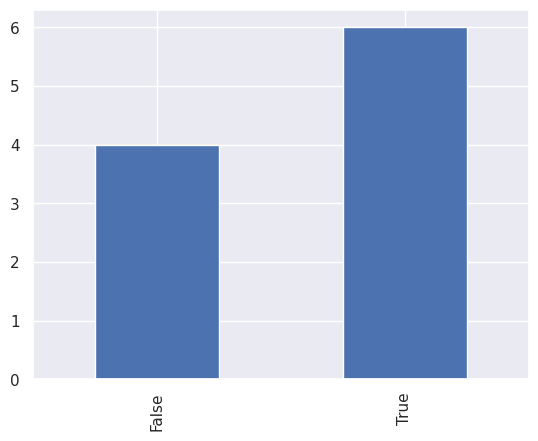

In [5]:
pd.Series(res.samples).value_counts().sort_index().plot.bar()

## Simple inference

In [6]:
%%treeppl coin samples=30000
model function coin1() => Real {
    assume p ~ Beta(2.0,2.0);
    return p;
}

<Axes: ylabel='Density'>

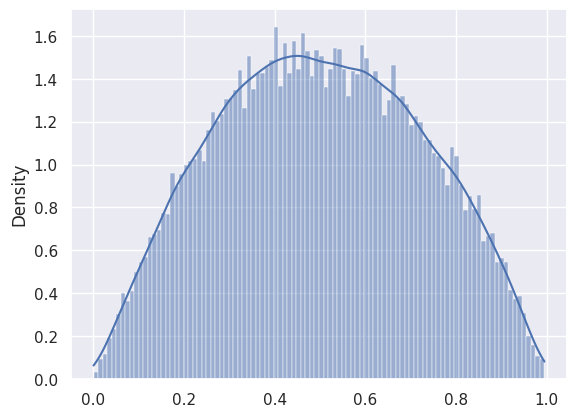

In [7]:
res = coin()
#res.samples
sns.histplot(
    x=res.samples, weights=res.nweights, bins=100, stat="density", kde=True
)

In [8]:
def myplot(res):
    sns.histplot(
        x=res.samples, weights=res.nweights, bins=100, stat="density", kde=True
    )

In [9]:
%%treeppl coin samples=30000
model function coin2() => Real {
    assume p ~ Beta(2.0,2.0);
    observe true ~ Bernoulli(p);
    return p;
}

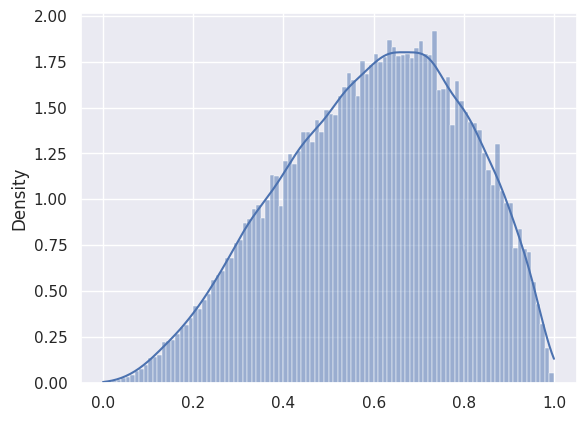

In [10]:
myplot(coin())

In [11]:
%%treeppl coin samples=30000
model function coin3() => Real {
    assume p ~ Beta(2.0,2.0);
    observe true ~ Bernoulli(p);
    observe true ~ Bernoulli(p);
    observe true ~ Bernoulli(p);
    observe false ~ Bernoulli(p);
    observe true ~ Bernoulli(p);
    observe true ~ Bernoulli(p);
    return p;
}

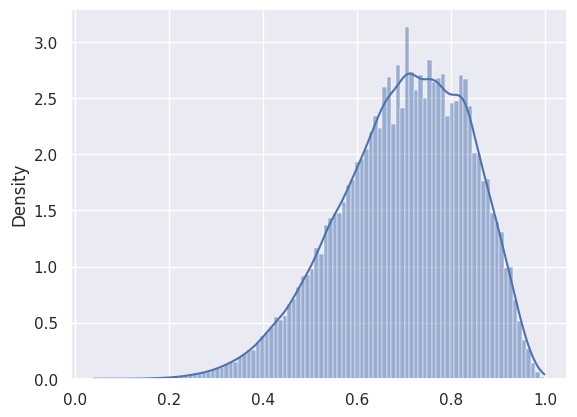

In [12]:
myplot(coin())

## Generlized Coin model

In [13]:
%%treeppl coin samples=50000

model function coin(outcomes: Bool[]) => Real {
  assume p ~ Uniform(0.0, 1.0);
  for i in 1 to (length(outcomes)) {
    observe outcomes[i] ~ Bernoulli(p);
  }
  return p;
}

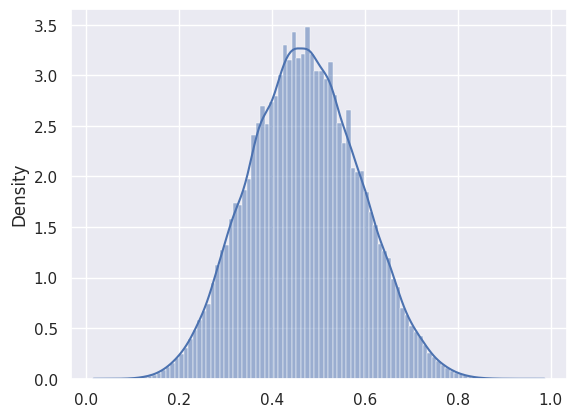

In [14]:
data =[
    False, True, True, False, True, False, False, True, True, False,
    True, False, True, False, False
]
myplot(coin(outcomes=data))

In [15]:
%%treeppl foo samples=40000

model function foo() => Real {
  assume choice ~ Bernoulli(0.7);
  if(choice){
    assume p ~ Gaussian(-2.0, 1.0);
    return p;
  }
  else{
    assume p ~ Gaussian(3.0, 1.0);
    return p;
  }
}

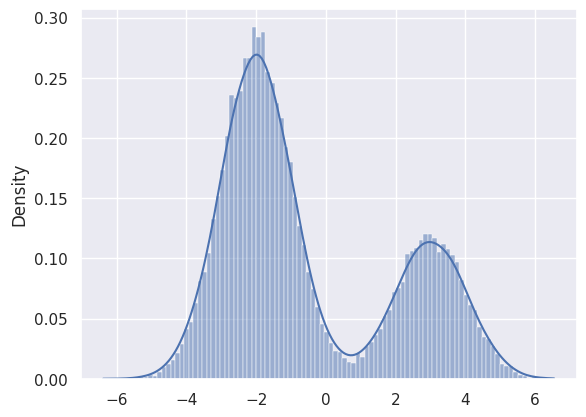

In [16]:
myplot(foo())

### Task

Try to run the model above using less data, and with another prior, e.g., using Beta. How is the change of prior affecting the result? What is the effect of the prior if you have a large number of observations?

## Exercise 1: Recursively Defined Models

**Geometric distribution:** X number of Bernoulli trials needed to get one success.\
**Parameter:** probability of success (0 < p ≤ 1)\
**Support:** x number of trials, (x ∈ {1,2,3,…})

In [17]:
%%treeppl geometric samples=10000

model function geometric(p : Real) => Int {
  assume cont ~ Bernoulli(p);
  if cont {
    return 1;
  }
  return 1 + geometric(p);
}

<Axes: ylabel='Count'>

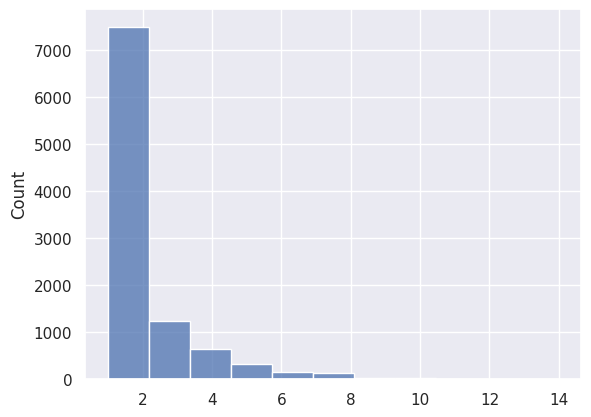

In [18]:
sns.histplot(x=geometric(p = 0.5).samples, binwidth=1.2)

## Exercise 2: A Graphical Model

$\alpha \sim \text{Exponential}(1)$\
$\beta \sim \text{Gamma}(0.1, 1)$\
$\theta_i \sim \text{Gamma}(\alpha, \beta)\quad i = 1, \ldots, N$\
$y_i \sim \text{Poisson}(\theta_i t_i) \quad i = 1, \ldots, N$

Implement this graphical model and infer $\alpha$.


In [19]:
%%treeppl pump samples=1000000
model function pump(y : Int[], t : Real[]) => Real {
  assume alpha ~ Exponential(1.0);
  assume beta ~ Gamma(0.1, 1.0);
  for i in 1 to (length(y)) {
    assume theta ~ Gamma(alpha, beta);
    observe y[i] ~ Poisson(theta * t[i]);
  }
  return alpha;
}

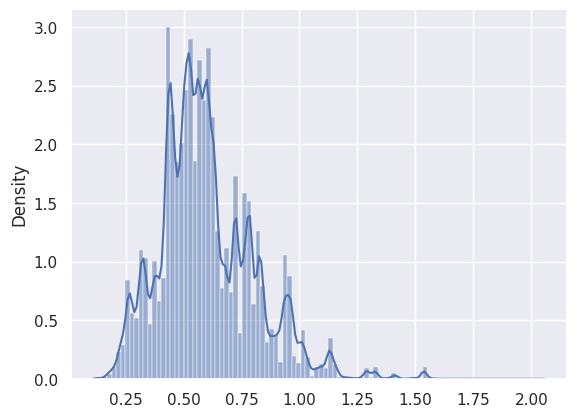

In [20]:
res = pump(
    y = [5, 1, 14, 3, 19, 1, 1, 4, 22],
    t = [94.3, 15.7, 62.9, 126, 5.24, 31.4, 1.05, 2.1, 10.5],
)
myplot(res)

## Exercise 3: Bayesian Linear Regression

Suppose you have the following data: `length = [55, 57, 52, 64, 53, 64]` and `age =
[4, 10, 2, 17, 6, 20]`, where the tuple `(length[i], age[i])` represents the length in cm and age in
weeks for a baby. Create a WebPPL/Stan script that infers a posterior distribution over the length of six months old
babies by using Bayesian linear regression of the form $l_i \sim N(\alpha + \beta a_i, \gamma)$, where $N$ is the normal distribution, $l_i$ the length, $a_i$ the age, and $\alpha$, $\beta$ and $\gamma$ are random variables.

In [21]:
%%treeppl linreg samples=100000

type LinRes =
  | LinRes {alpha : Real, beta : Real, gamma : Real}

model function linreg(lengths : Real[], ages : Real[]) => LinRes {
  assume alpha ~ Uniform(0.0, 200.0);
  assume beta ~ Uniform(0.0, 10.0);
  assume gamma ~ Uniform(0.0, 100.0);
  for i in 1 to (length(ages)) {
    observe lengths[i] ~ Gaussian(alpha + beta * ages[i], gamma);
  }
  return LinRes {alpha = alpha, beta = beta, gamma = gamma};
}

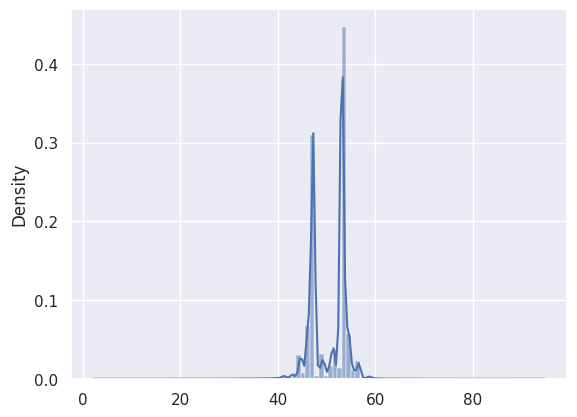

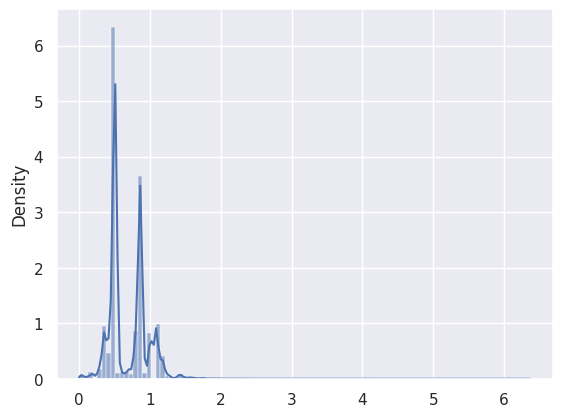

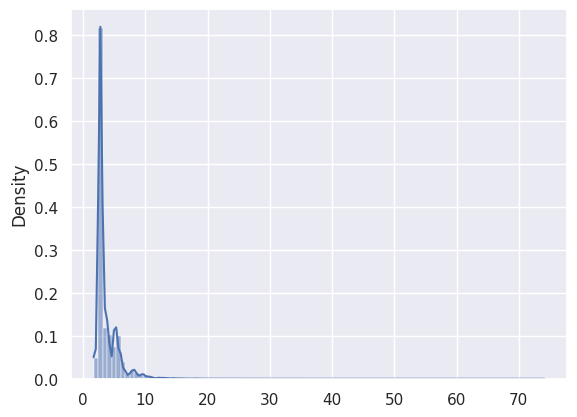

In [22]:
res = linreg(
    lengths = [55, 57, 52, 64, 53, 64],
    ages = [4, 10, 2, 17, 6, 20],
)

def plotWithMapping(f, res):
    data = np.array(list(map(f, res.samples)))
    sns.histplot(
        x=data, weights=res.nweights, bins=100, stat='density', kde=True
    )
    plt.show()

plotWithMapping(lambda x: x.alpha, res)
plotWithMapping(lambda x: x.beta, res)
plotWithMapping(lambda x: x.gamma, res)